Epigenetic Reader Protein Binding  
============================

Self-consistent field theory for multiple marks
------------------------------------------------------

Questions:

    -in eval_f_bind why introduce j_int. In theory had (0 marks 2 bound) = (0 marks 0 bound). Is it to take self-interaction into account? 
    - based on overleaf doc, only need <s> to get f bar, which can then use to get <s_i s_j>, correct? similar to what was done below with s2_bind
    - how to verify <s_i s_j>, or (eventually) structure factor? simulation data to compare to?

In [1]:
import sys
sys.path.insert(1, './wlcstat/')

In [2]:
import numpy as np
import scipy.special as sp
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [3]:
def eval_f_bind(n_b, n_m, e_m = -1.5, j_int = -3.92):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        Number of reader proteins bound to the nucleosome
    n_m : integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind = 0

    if n_b == 0:
        f_bind = 0
    elif n_b == 1:
        if n_m == 0:
            f_bind = -np.log(2)
        elif n_m == 1:
            f_bind = -np.log(1. + np.exp(-e_m))
        elif n_m == 2:
            f_bind = e_m - np.log(2)
    elif n_b == 2:
        if n_m == 0:
            f_bind = j_int
        elif n_m == 1:
            f_bind = e_m + j_int
        elif n_m == 2:
            f_bind = 2 * e_m + j_int
    
    return f_bind

In [4]:
def eval_opt_func(x, mu, e_m, v_int, f_om, phi_c):
    r"""
    eval_opt_func - Evaluate the binding state for 
    
    """

    # Convert to average bound variable and phi variable
    n_bind = len(mu) # number of reader protein types
    s_bind = 2. * np.exp(x) / (1 + np.exp(x))
    
    phi_bind = np.zeros(n_bind)
    for mark in range(n_bind):
        ind0 = mark * 3 
#         phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 2)] * s_bind[ind0:(ind0 + 2)]) # ORGINAL. OBOE
        phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)]) # MINE
    erg_int = np.matmul(v_int, phi_bind)
    
    # Evaluate the optimization function
    opt_func = np.zeros(n_bind * 3)
    
    ind = 0
    for mark in range(n_bind): # for each reader protein/ mark type
        for om in range(3): # for each possible number of marked tails on nucl
            f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
            f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
            q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])
            #calculate the difference b/w new and previous avg binding state 
            opt_func[ind] = s_bind[ind] - (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
                                             2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q        
            ind += 1
    
    return opt_func

In [5]:
def eval_s_bind(mu, e_m, v_int, f_om, phi_c):
    # Convert to average bound variable and phi variable
    n_bind = len(mu)
    for mark in range(n_bind):
        ind0 = mark * 3
        indf = ind0 + 3
        f_om[ind0:indf] /= np.sum(f_om[ind0:indf])
    
    x = np.zeros(n_bind * 3)
    x0 = np.zeros(n_bind * 3)
    data = (mu, e_m, v_int, f_om, phi_c)
    
    #doing unbounded non-linear solver for x, then calc (bounded) var s_bind
    x = opt.fsolve(eval_opt_func, x0=x0, args=tuple(data))
    
    s_bind = 2. * np.exp(x) / (1 + np.exp(x))
    
    return s_bind

In [6]:
def eval_s2_bind(s_bind, mu, e_m, v_int, f_om, phi_c):
    r"""
    eval_s2_bind - Evaluate the binding state for 
    
    """

    # Convert to average bound variable and phi variable
    n_bind = len(mu)
    s2_bind = np.zeros(n_bind * 3)
    
    phi_bind = np.zeros(n_bind)
    for mark in range(n_bind):
        ind0 = mark * 3
        phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)]) 
    erg_int = np.matmul(v_int, phi_bind)
    
    
    # Evaluate the optimization function
    opt_func = np.zeros(n_bind * 3)
    
    ind = 0
    for mark in range(n_bind):
        for om in range(3):
#            f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
#            f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
            f_bind_1 = eval_f_bind(1, om, e_m[mark], 0 * v_int[mark, mark])
            f_bind_2 = eval_f_bind(2, om, e_m[mark], 0 * v_int[mark, mark])
            q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])
            s2_bind[ind] = (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
                                             4 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q        
            ind += 1
    
    return s2_bind

Test the optimization procedure

In [7]:
n_bind = 2 #types of proteins/marks

mu = np.array([-4.5, -5]) #chemical potential in solution
e_m = np.array([-1.5, -1.5]) #binding energy
f_om = np.array([0.5, 0, 0.5, 0.75, 0, 0.25]) # fraction of nucleosomes with 0,1,2 marks per protein type
v_int = np.array([[-3.92, 3.0],[3.0, -3.92]]) # protein-protein interaction param
phi_c = 0.6 # avg amount of chromosome 

x = np.zeros(n_bind * 3)

eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)

array([0.9731654 , 0.91545365, 0.77805158, 0.94474312, 0.82268372,
       0.52872238])

In [8]:
s_bind = eval_s_bind(mu, e_m, v_int, f_om, phi_c)
s2_bind = eval_s2_bind(s_bind, mu, e_m, v_int, f_om, phi_c)

In [9]:
s_bind
#average binding state for protein 1 marks = 0,1,2 ; protein 2 marks = 0,1,2

array([0.03444556, 0.10958987, 0.2921737 , 0.01778006, 0.05488237,
       0.13774465])

In [10]:
s2_bind - s_bind ** 2

array([0.0287417 , 0.06745299, 0.04826242, 0.01092154, 0.02741412,
       0.03136135])

## Langmuir isotherm analysis

In [19]:
n_bind = 1 #types of proteins/marks

e_m = np.array([-1.5]) #binding energy
# e_m = np.array([0]) #binding energy
f_om = np.array([1/3, 1/3, 1/3]) # fraction of nucleosomes with 0,1,2 marks per protein type
# v_int = np.array([[-3.92]]) # protein-protein interaction param
v_int = np.array([[0]]) # protein-protein interaction param
phi_c = 1# avg amount of chromosome 

x = np.zeros(n_bind * 3)

# eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)

In [20]:
mu_array = np.arange(-10, 10, .1)
# mu_array = np.arange(-6, -1, 2)
f_bar_arr = np.zeros(len(mu_array))
s_bind_0sig = np.zeros(len(mu_array))
s_bind_1sig = np.zeros(len(mu_array))
s_bind_2sig = np.zeros(len(mu_array))
for i,mu in enumerate(mu_array):
    s_bind = eval_s_bind([mu], e_m, v_int, f_om, phi_c)
#     print("s_bind:")
#     print(s_bind)
#     print(s_bind[0:(0 + 3)])
#     f_bar = np.sum(f_om[0:(0 + 3)] * s_bind[0:(0 + 3)])
    f_bar = np.sum(f_om * s_bind)
    s_bind_0sig[i] = s_bind[0]
    s_bind_1sig[i] = s_bind[1]
    s_bind_2sig[i] = s_bind[2]
    f_bar_arr[i] = f_bar
# f_bar_arr

<Figure size 640x480 with 0 Axes>

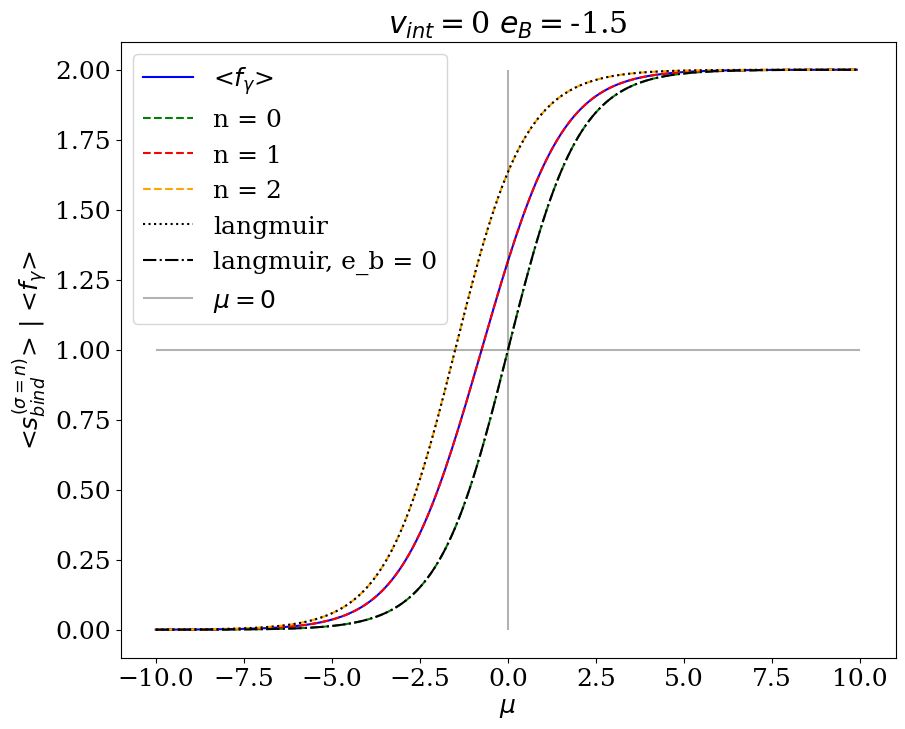

In [21]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(mu_array, f_bar_arr, label = "<$ f_{\gamma} $>", color = "blue")
# plt.xlabel("$\mu$")
# plt.ylabel("<$ f_{\gamma} $>")

plt.plot(mu_array, s_bind_0sig, linestyle = "--", label = "n = 0", color = "green")
# plt.xlabel("$\mu$")
# plt.ylabel("<$ s_{bind}^{(\sigma = 0)}$>")

plt.plot(mu_array, s_bind_1sig, linestyle = "--", label = "n = 1", color = "red")
# plt.xlabel("$\mu$")
# plt.ylabel("<$ s_{bind}^{(\sigma = 1)}$>")

plt.plot(mu_array, s_bind_2sig, linestyle = "--", label = "n = 2", color = "orange")
# plt.xlabel("$\mu$")
# plt.ylabel("<$ s_{bind}^{(\sigma = 2)}$>")

# LANGMUIR. Assumptions only valid when v_int = 0, and for sigma =0 or 2 (all sites identical)
K = np.exp(-e_m)
plt.plot(mu_array, 2*K*np.exp(mu_array) / (1+ K*np.exp(mu_array)), label = "langmuir", linestyle = ":", color = "black")

K = np.exp(-0)  # sigma = 0 - all binding energies are 0
plt.plot(mu_array, 2*K*np.exp(mu_array) / (1+ K*np.exp(mu_array)), label = "langmuir, e_b = 0", linestyle = "-.", color = "black")

plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
plt.xlabel("$\mu$")
plt.title("$v_{int} = $" + str(v_int[0][0]) +  " $e_B = $" + str(e_m[0]))
plt.hlines(1, -10, 10, color = "black", alpha = 0.3)
# plt.vlines(-.75, 0,2, color = "black", alpha = 0.3, label = "$\mu = -0.75$")
plt.vlines(-0, 0,2, color = "black", alpha = 0.3, label = "$\mu = 0$")
plt.legend()

# why is s_bind = 2 * (exp(x \ (1 + exp)))? how did that realtion come about. it is to allow for unbounded minimizationq
#check solver- intial conditions? 

## $\langle s_{i}^{(\gamma_1)} s_{j}^{(\gamma_1')} \rangle$ calculation

In [ ]:
def eval_f_bind_vec(n_b, n_m_arr, e_m = -1.5, j_int = -3.92):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        array of Number of reader proteins bound to the nucleosome
    n_m_arr : arr of integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind_arr = np.zeros(len(n_m_arr))
    for i,n_m in enumerate(n_m_arr):
        f_bind = 0
        if n_b == 0:
            f_bind = 0
        elif n_b == 1:
            if n_m == 0:
                f_bind = -np.log(2)
            elif n_m == 1:
                f_bind = -np.log(1. + np.exp(-e_m))
            elif n_m == 2:
                f_bind = e_m - np.log(2)
        elif n_b == 2:
            if n_m == 0:
                f_bind = j_int
            elif n_m == 1:
                f_bind = e_m + j_int
            elif n_m == 2:
                f_bind = 2 * e_m + j_int
        f_bind_arr[i] = f_bind
    return f_bind_arr

In [ ]:
# need to produce rank 2 tensor that, given two protein types, 
# find avg of product of s for index ij
def eval_sisj_bind(s_bind, mu, e_m, v_int, f_om, phi_c, poly_marks, gam1_ind, gam2_ind):
    '''
    poly marks (array of arrays) contains an array of marks per nucleosome for each protein type
    gam1_ind (int) is the index of first protein
    gam2_ind (int) is the index of second protein
    '''
    
    n_bind = len(mu)
    # evaluate eqn 85 for each index ij
 
    phi_bind = np.zeros(n_bind) #phi_c times f_gamma
    for mark in range(n_bind):
        ind0 = mark * 3             # VVV calc of bar{f}_\gamma (eqn 86) VVV
        phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)]) 
    erg_int = np.matmul(v_int, phi_bind) #sum over gamma 2 of int and phi and f
    
    coef1 = erg_int[gam1_ind] + mu[gam1_ind] 
    coef2 = erg_int[gam2_ind] + mu[gam2_ind]
    
    #make vector form of f_bind
    f_bind_g1_s1 = eval_f_bind_vec(1, poly_marks[gam1_ind], e_m[gam1_ind])
    f_bind_g1_s2 = eval_f_bind_vec(2, poly_marks[gam1_ind], e_m[gam1_ind])
    f_bind_g2_s1 = eval_f_bind_vec(1, poly_marks[gam2_ind], e_m[gam2_ind])
    f_bind_g2_s2 = eval_f_bind_vec(2, poly_marks[gam2_ind], e_m[gam2_ind])
    
    #combine coef and f_bind to create 4 dif energies needed
#     - each should be rank 2 tensors
    
    exp_g1_s1 = np.exp(coef1 + f_bind_g1_s1)
    exp_g1_s2 = np.exp(2*coef1 + f_bind_g1_s2)
    exp_g2_s1 = np.exp(coef2 + f_bind_g2_s1)
    exp_g2_s2 = np.exp(2*coef2 + f_bind_g2_s2)
    
    exp_11 = np.outer(exp_g1_s1, exp_g2_s1)
    exp_12 = np.outer(exp_g1_s1, exp_g2_s2)
    exp_21 = np.outer(exp_g1_s2, exp_g2_s1)
    exp_22 = np.outer(exp_g1_s2, exp_g2_s2)
    
#     # calc q_0 (all probabilities)
    q = 1 + np.outer(exp_g1_s1, exp_g1_s1) + np.outer(exp_g2_s1, exp_g2_s1)\
    + np.outer(exp_g1_s2, exp_g1_s2) + np.outer(exp_g2_s2, exp_g2_s2)\
    + exp_11 + exp_12 + exp_21 + exp_22
    
    #calculate average matrix (eq 85)
    sisj_bind = (exp_11 + exp_12 + exp_21 + exp_22) / q
    return sisj_bind 

In [ ]:
n_bind = 2 #types of proteins/marks

mu = np.array([-4.5, -5]) #chemical potential in solution
e_m = np.array([-1.5, -1.5]) #binding energy
f_om = np.array([0.5, 0, 0.5, 0.75, 0, 0.25]) # fraction of nucleosomes with 0,1,2 marks per protein type
v_int = np.array([[-3.92, 3.0],[3.0, -3.92]]) # protein-protein interaction param
phi_c = 0.6 # avg amount of chromosome 

x = np.zeros(n_bind * 3)

marks_1 = [0,2,0,2] # marks for protein 1
marks_2 = [0,0,0,2] # marks for protein 2
poly_marks = [marks_1, marks_2]
eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)

In [ ]:
s_bind = eval_s_bind(mu, e_m, v_int, f_om, phi_c)
s2_bind = eval_s2_bind(s_bind, mu, e_m, v_int, f_om, phi_c)

In [ ]:
eval_sisj_bind(s_bind, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 0)

## Determine the effective $\chi$-parameter matrix (andy)

In [ ]:
def eval_chi_mat(mu, e_m, v_int, f_om, phi_c):
    n_bind = len(mu)
    chi_mat = np.zeros((3 * n_bind, 3 * n_bind))
    
    s_bind = eval_s_bind(mu, e_m, v_int, f_om, phi_c)
    
    for m1 in range(n_bind):
        for s1 in range(3):
            i1 = m1 * 3 + s1
            for m2 in range(n_bind):
                for s2 in range(3):
                    i2 = m2 * 3 + s2
                    e12 = 0.5 * s_bind[i1] * v_int[m1, m2] * s_bind[i2]
                    e11 = 0.5 * s_bind[i1] * v_int[m1, m1] * s_bind[i1]
                    e22 = 0.5 * s_bind[i2] * v_int[m2, m2] * s_bind[i2]
                    chi_mat[i1, i2] = e12 - 0.5 * (e11 + e22)
    
    return chi_mat

In [ ]:
n_bind = 2

mu = np.array([-5, -5])
e_m = np.array([-1.5, -1.5])
f_om = np.array([0.5, 0, 0.5, 0.5, 0, 0.5])
v_int = np.array([[-3.92, .0],[.0, -3.92]])
phi_c = 0.6

s_bind = eval_s_bind(mu, e_m, v_int, f_om, phi_c)
chi_mat = eval_chi_mat(mu, e_m, v_int, f_om, phi_c)

In [ ]:
print(chi_mat[0, 2])
print(chi_mat[3, 5])
print(chi_mat[2, 5])

In [ ]:
s_bind

In [ ]:
chi_mat